In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pickle

In [109]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [112]:
df_wind = pd.read_csv('../../1_data_analysis_and_preproc/intermediate/wind/final_wind_df.csv')

In [113]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1


In [114]:
import numpy as np
import pandas as pd

np.random.seed(10)

# Define the desired subset size per asset (adjust as needed)
subset_size_percentage = 0.01  # Adjust as needed

# Get the unique asset identifiers from the original DataFrame
unique_assets = df_wind['asset_id'].unique()

# Find the minimum number of rows among all assets
min_rows = min(df_wind['asset_id'].value_counts())

# Calculate the subset size based on the minimum number of rows
subset_size = int(subset_size_percentage * min_rows)

# Initialize an empty list to store the sampled data
subset_data = []

# Iterate over each asset, sample rows, and append to subset_data
for asset in unique_assets:
    # Filter the DataFrame for the current asset
    asset_df = df_wind[df_wind['asset_id'] == asset]
    
    # Sample rows from the asset DataFrame
    sampled_group = asset_df.sample(n=subset_size, replace=False)
    subset_data.append(sampled_group)

# Concatenate the sampled data from all assets into a single DataFrame
df_subset = pd.concat(subset_data)


In [115]:
df_subset['asset_id'].nunique()

71

In [116]:
len(df_subset)

42813

In [117]:
df_subset = df_subset.reset_index(drop=True)

wind_direction, power_average, exterior_temperature

In [118]:
df_subset

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,2021-12-20 22:50:00,8.70,177.00,909.00,16.08,7.00,12.00,1
1,11,2021-09-19 20:50:00,2.70,-80.00,20.00,6.66,11.00,27.00,1
2,11,2022-05-21 13:20:00,6.20,-240.00,451.00,13.60,22.00,30.00,1
3,11,2022-02-02 11:40:00,9.10,114.00,1250.00,16.55,10.00,13.00,1
4,11,2022-08-20 04:10:00,5.30,-237.00,186.00,10.44,22.00,34.00,1
...,...,...,...,...,...,...,...,...,...
42808,512,2022-11-15 09:20:00,17.21,208.27,2001.81,13.95,11.40,18.51,5
42809,512,2021-10-06 13:20:00,4.71,46.93,178.67,8.17,20.21,30.11,5
42810,512,2021-03-21 19:10:00,6.03,73.27,404.91,10.11,10.72,19.32,5
42811,512,2021-01-22 12:30:00,7.49,258.76,1002.76,13.04,2.86,10.12,5


In [119]:
X = df_subset[['asset_id','read_at' ,'wind_direction', 'power_average', 'exterior_temperature']]
X.head()

,asset_id,read_at,wind_direction,power_average,exterior_temperature
0,11,2021-12-20 22:50:00,177.0,909.0,7.0
1,11,2021-09-19 20:50:00,-80.0,20.0,11.0
2,11,2022-05-21 13:20:00,-240.0,451.0,22.0
3,11,2022-02-02 11:40:00,114.0,1250.0,10.0
4,11,2022-08-20 04:10:00,-237.0,186.0,22.0


In [120]:
X.dtypes

asset_id                  int64
read_at                  object
wind_direction          float64
power_average           float64
exterior_temperature    float64
dtype: object

In [121]:
X['read_at'] = pd.to_datetime(X['read_at'])

/tmp/ipykernel_8548/2166665197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['read_at'] = pd.to_datetime(X['read_at'])


In [122]:
X['read_at'] = X['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)

/tmp/ipykernel_8548/3417196857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['read_at'] = X['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)


In [123]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42813 entries, 0 to 42812
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   asset_id              42813 non-null  int64  
 1   read_at               42813 non-null  float64
 2   wind_direction        42813 non-null  float64
 3   power_average         42813 non-null  float64
 4   exterior_temperature  42813 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.6 MB


In [124]:
X = X.astype(np.float32)

In [125]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42813 entries, 0 to 42812
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   asset_id              42813 non-null  float32
 1   read_at               42813 non-null  float32
 2   wind_direction        42813 non-null  float32
 3   power_average         42813 non-null  float32
 4   exterior_temperature  42813 non-null  float32
dtypes: float32(5)
memory usage: 836.3 KB


In [126]:
X_grouped = X.groupby('asset_id')

In [127]:
def zoom_in_plot(X_train, y_pred, km, sz, title:str):
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 4, width_ratios=[5, 1, 3, 1], height_ratios=[1, 1, 1])

    for yi in range(3):
        # Main plot with more width
        ax = plt.subplot(gs[yi, 0])
        for xx in X_train[y_pred == yi]:  
            ax.plot(xx.ravel(), "k-", alpha=0.2)
        ax.plot(km.cluster_centers_[yi].ravel(), "r-")
        ax.set_xlim(0, sz)
        ax.set_ylim(-4, 4)
        ax.text(0.55, 0.85, 'Cluster %d' % (yi + 1), transform=ax.transAxes)
        if yi == 0:
            ax.set_title(f"{title} $k$-means")

        # Zoomed-in plot
        axins = plt.subplot(gs[yi, 2])
        for xx in X_train[y_pred == yi]:  
            axins.plot(xx.ravel(), "k-", alpha=0.2)
        axins.plot(km.cluster_centers_[yi].ravel(), "r-")
        axins.set_xlim(200, 220)
        axins.set_ylim(-3, 3)
        mark_inset(ax, axins, loc1=2, loc2=3, fc="None", ec="g")

    # Adjust spacing between the two plots in the same row
    plt.subplots_adjust(wspace=0)

    # plt.tight_layout()
    plt.show()

## Time Series Clustering with all important variables

https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py

### Euclidean k-Means

In [128]:
def clustering_score(estimator, X, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    labels = estimator.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    final_score = silhouette_weight * silhouette + davies_bouldin_weight * davies_bouldin
    return final_score

In [129]:
X_train = X.loc[:,'read_at':]

In [130]:
seed = 0

In [133]:
# Define the parameter grid
param_grid = {
    'n_clusters': [2, 3, 4, 5, 10],
}

euc_k_means_clust = TimeSeriesKMeans(verbose=False, random_state=seed)

# Initialize GridSearchCV
grid_search = GridSearchCV(euc_k_means_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END .......................................n_clusters=2; total time= 1.6min
[CV] END .......................................n_clusters=2; total time= 1.6min
[CV] END .......................................n_clusters=4; total time= 2.5min
[CV] END .......................................n_clusters=4; total time= 2.5min
[CV] END .......................................n_clusters=3; total time= 2.6min
[CV] END .......................................n_clusters=3; total time= 2.6min
[CV] END .......................................n_clusters=5; total time= 5.8min
[CV] END .......................................n_clusters=5; total time= 6.0min
[CV] END ......................................n_clusters=10; total time= 9.2min
[CV] END ......................................n_clusters=10; total time= 9.4min


GridSearchCV(cv=2, estimator=TimeSeriesKMeans(random_state=0, verbose=False),
             n_jobs=-1, param_grid={'n_clusters': [2, 3, 4, 5, 10]},
             scoring=<function clustering_score at 0x7f5f9e81b560>, verbose=2)

In [134]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,45.886305,1.143262,50.890235,2.077209,2,{'n_clusters': 2},0.562648,0.564563,0.563605,0.000957,1
1,68.391008,2.119692,86.294613,2.972034,3,{'n_clusters': 3},0.546540,0.544591,0.545566,0.000975,2
2,66.052293,31.508110,84.641274,32.470166,4,{'n_clusters': 4},0.537651,0.537860,0.537756,0.000104,3
3,113.085024,29.094768,241.060324,37.871273,5,{'n_clusters': 5},0.532013,0.531093,0.531553,0.000460,4
4,280.732384,3.807711,277.172408,2.870257,10,{'n_clusters': 10},0.521811,0.521241,0.521526,0.000285,5


In [135]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Clustering Score:", best_score)

Best Parameters: {'n_clusters': 2}
Best Clustering Score: 0.5636053214666277


In [136]:
# Grouping by 'asset_id' and storing each group as an array
grouped_arrays_all = [group[['read_at', 'wind_direction', 'power_average', 'exterior_temperature']].values \
                    for _, group in X.groupby('asset_id')]

In [137]:
X_train = grouped_arrays_all

In [138]:
seed = 42

In [139]:
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

sz = X_train.shape[1]

using 3 clusters as its the second best clustering partition and then the can be more distributed

Euclidean k-means
4520.254 --> 2301.838 --> 2301.838 --> 


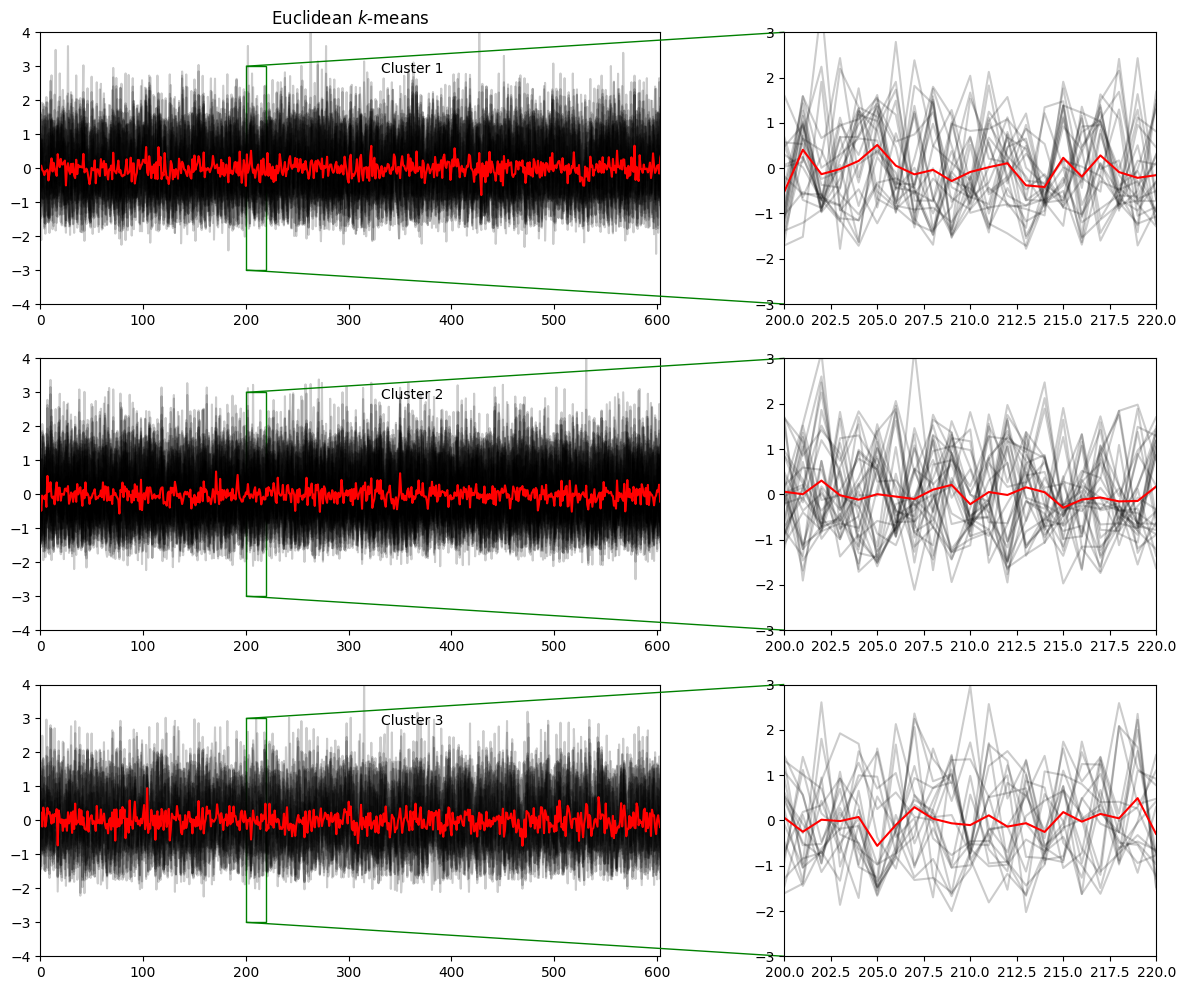

In [140]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred_euclidean = km.fit_predict(X_train)

zoom_in_plot(X_train, y_pred_euclidean, km, sz, 'Euclidean')


In [141]:
with open('intermediate_without_out/euclidean_wind.pickle', 'wb') as f:
    pickle.dump(km, f)

In [142]:
assets_per_cluster_euclidean = pd.DataFrame()

assets_per_cluster_euclidean['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_euclidean['cluster_label'] = y_pred_euclidean

In [143]:
assets_clusters = assets_per_cluster_euclidean.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 2, 3, 6, 7, 9, 12, 14, 20, 22, 23, 26, 27, 30, 46, 48, 51, 52, 55, 58, 60, 61, 63]
Cluster 1: [4, 5, 8, 11, 13, 18, 21, 24, 25, 28, 29, 31, 34, 35, 36, 37, 38, 39, 42, 44, 45, 49, 53, 54, 62, 66, 67, 68, 69]
Cluster 2: [10, 15, 16, 17, 19, 32, 33, 40, 41, 43, 47, 50, 56, 57, 59, 64, 65, 70]


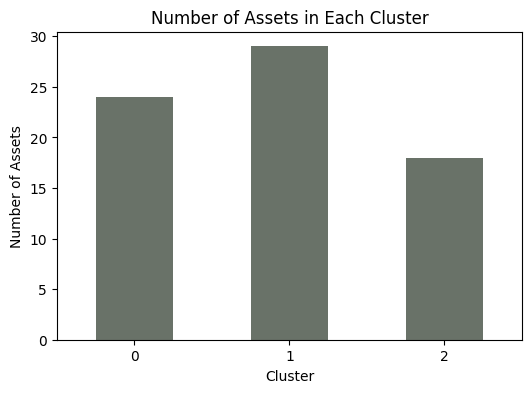

In [144]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_euclidean['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [145]:
asset_per_cluster = pd.DataFrame(columns=['Metric', 'Cluster 0', 'Cluster 1', 'Cluster 2'])

for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[0, column_name] = count

asset_per_cluster.loc[0, 'Metric'] = 'Euclidean'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,24,29,18


In [165]:
merged_df = df_wind.merge(assets_per_cluster_euclidean, on='asset_id', how='left')

In [167]:
merged_df.to_csv('intermediate_without_out/results_clean_wind_euclidean.csv', index = False)

### DBA k-Means

In [146]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)

y_pred_DBA = dba_km.fit_predict(X_train)

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s


2796.534 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


1843.372 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


1843.372 --> 
Init 2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.8s


2791.977 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.3s


1848.445 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s


1848.445 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.2s


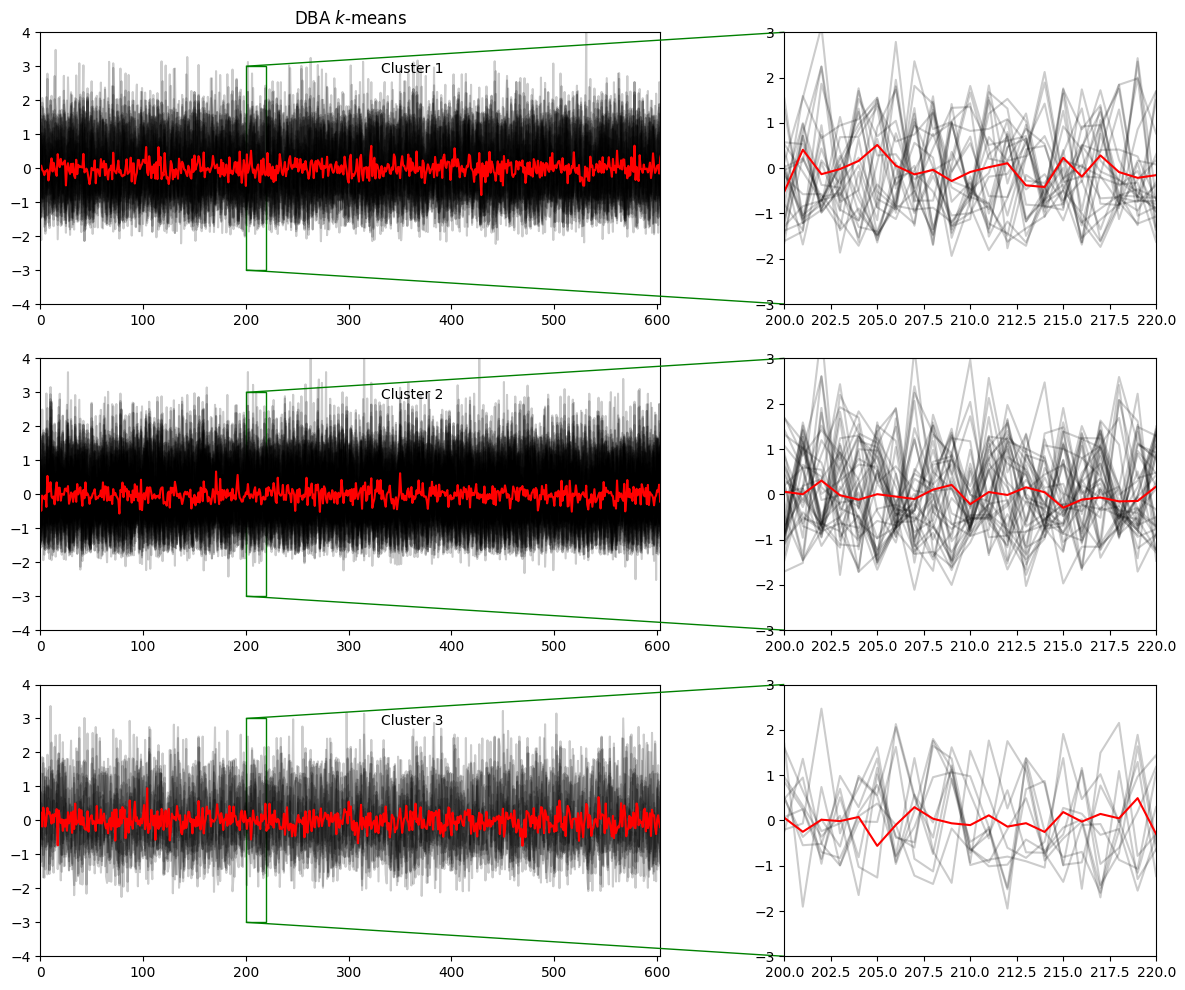

In [147]:
zoom_in_plot(X_train, y_pred_DBA, km, sz, 'DBA')

In [148]:
with open('intermediate_without_out/DBA_wind.pickle', 'wb') as f:
    pickle.dump(dba_km, f)

In [149]:
assets_per_cluster_dba = pd.DataFrame()

assets_per_cluster_dba['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_dba['cluster_label'] = y_pred_DBA

In [150]:
assets_clusters = assets_per_cluster_dba.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [1, 7, 10, 17, 19, 20, 21, 30, 35, 36, 37, 38, 42, 44, 46, 49, 51, 52, 53, 56, 60, 61, 69, 70]
Cluster 1: [2, 3, 5, 8, 9, 12, 14, 15, 16, 18, 22, 23, 24, 25, 26, 27, 28, 31, 32, 34, 40, 41, 43, 45, 47, 50, 55, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68]
Cluster 2: [0, 4, 6, 11, 13, 29, 33, 39, 48, 54]


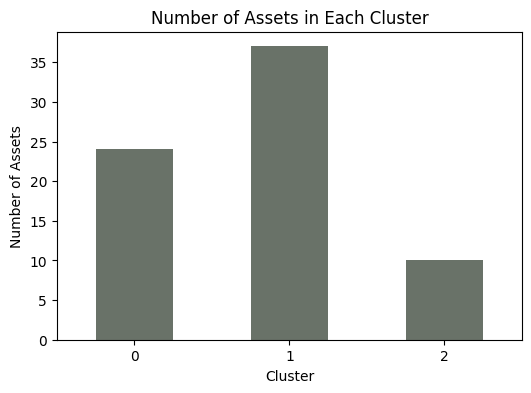

In [151]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_dba['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [152]:
for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[1, column_name] = count

asset_per_cluster.loc[1, 'Metric'] = 'DBA'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,24,29,18
1,DBA,24,37,10


In [162]:
merged_df = df_wind.merge(assets_per_cluster_dba, on='asset_id', how='left')

In [164]:
merged_df.to_csv('intermediate_without_out/results_clean_wind_dba.csv', index = False)

## Soft DTW k-means

In [153]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
                           
y_pred_soft_dtw = sdtw_km.fit_predict(X_train)

Soft-DTW k-means


8165988.445 --> 3407442.514 --> 3403595.200 --> 3401376.980 --> 3400350.283 --> 3399913.316 --> 3399198.181 --> 3399181.336 --> 3399179.384 --> 3399179.521 --> 3399175.107 --> 3399174.373 --> 3399174.031 --> 3399158.813 --> 3399154.672 --> 3399154.625 --> 3399154.593 --> 3399154.596 --> 3399154.595 --> 3399154.595 --> 


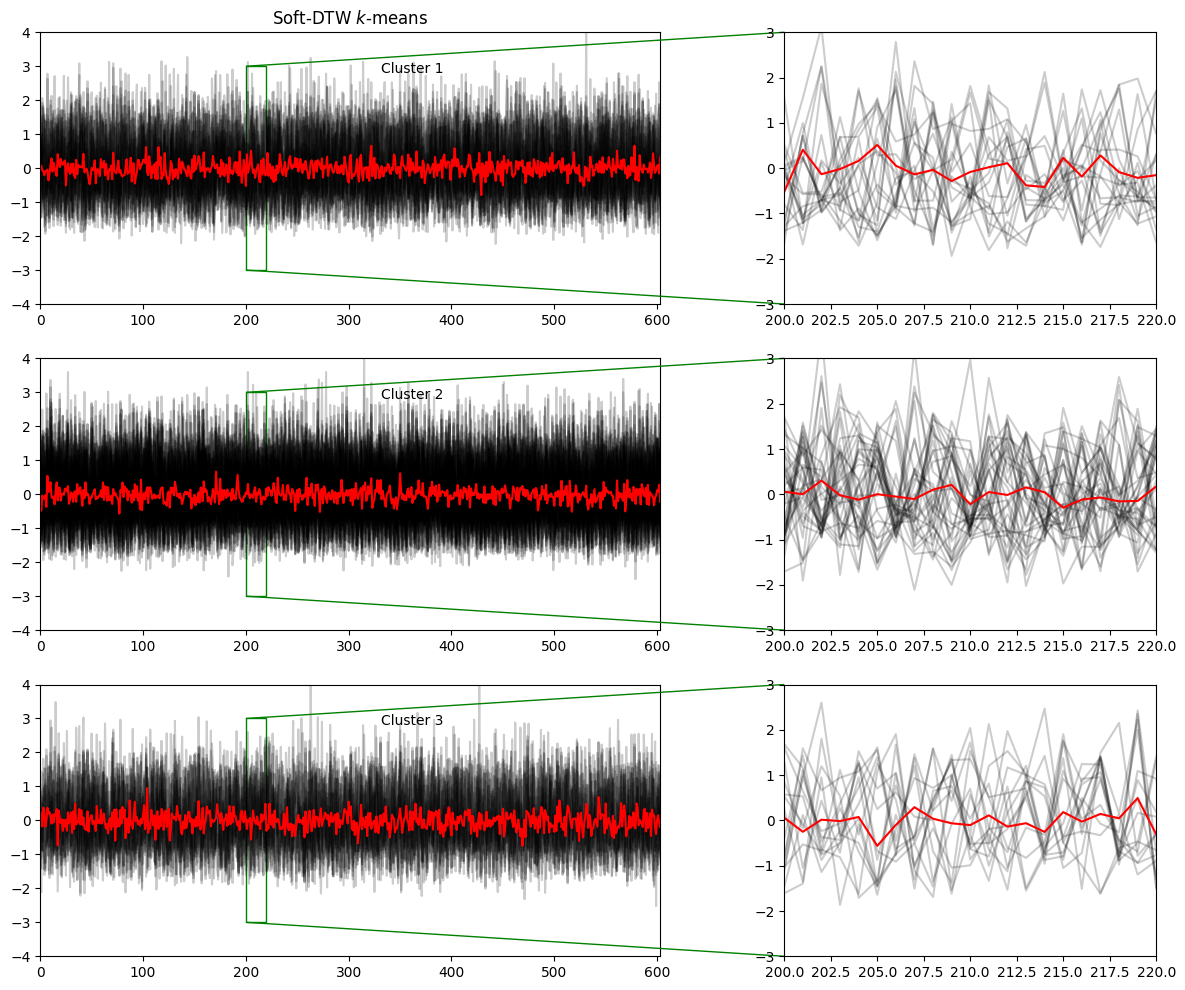

In [154]:
zoom_in_plot(X_train, y_pred_soft_dtw, km, sz, 'Soft-DTW')

In [155]:
with open('intermediate_without_out/dba_euclidean_wind.pickle', 'wb') as f:
    pickle.dump(dba_km, f)

In [156]:
assets_per_cluster_soft_dtw = pd.DataFrame()

assets_per_cluster_soft_dtw['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_soft_dtw['cluster_label'] = y_pred_soft_dtw

In [157]:
assets_clusters = assets_per_cluster_soft_dtw.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 17, 19, 21, 30, 33, 35, 36, 37, 38, 42, 44, 49, 51, 52, 53, 60, 61, 69]
Cluster 1: [2, 4, 5, 6, 8, 11, 12, 13, 14, 15, 16, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 39, 43, 45, 47, 54, 55, 57, 58, 59, 63, 64, 65, 67, 68]
Cluster 2: [3, 7, 9, 10, 18, 20, 40, 41, 46, 48, 50, 56, 62, 66, 70]


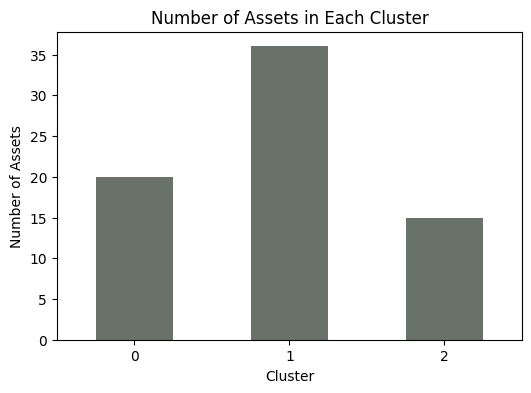

In [158]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_soft_dtw['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [159]:
for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[2, column_name] = count

asset_per_cluster.loc[2, 'Metric'] = 'Soft DTW'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,24,29,18
1,DBA,24,37,10
2,Soft DTW,20,36,15


In [160]:
merged_df = df_wind.merge(assets_per_cluster_soft_dtw, on='asset_id', how='left')

In [161]:
merged_df.to_csv('intermediate_without_out/results_clean_wind_soft_dtw.csv', index = False)